<a href="https://colab.research.google.com/github/kuir-juach/Dropout_Model_training_summative/blob/main/final_KuirSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
#Data Loading
data = pd.read_csv("/content/School_dataset.csv")

In [3]:

print("Column names in the dataset:", data.columns)

Column names in the dataset: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 

In [4]:
#Data Preprocessing
print("Missing values:\n", data.isnull().sum())
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(include=["object"]).columns

#Filling missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)


Missing values:
 Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                  

<ipython-input-4-7a1eaaba0926>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


In [5]:
# One-hot encoding for categorical variables
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(drop="first", sparse_output=False)
    encoded_cols = encoder.fit_transform(data[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
    data = data.drop(categorical_cols, axis=1)
    data = pd.concat([data, encoded_df], axis=1)

target_column = 'Target_Enrolled'  # Change this if you want to use 'Target_Graduate'
if target_column not in data.columns:
    raise KeyError(f"'{target_column}' column not found in the dataset. Available columns: {data.columns.tolist()}")


In [6]:
# Ensure target variable is binary
if data[target_column].nunique() > 2:
    raise ValueError("Target variable must be binary (0 and 1).")

X = data.drop(target_column, axis=1)  # Features
y = data[target_column]  # Target variable

# Step 3: Preprocess the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
# Step 4: Define a function to evaluate models
def evaluate_model(model, X_test, y_test, model_type="neural_network"):
    if model_type == "neural_network":
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

In [8]:
# Step 5: Neural Network Implementation
def create_nn_model(optimizer="adam", regularizer=None, dropout_rate=0.0, early_stopping=False):
    model = tf.keras.Sequential([
        Dense(16, activation="relu", kernel_regularizer=regularizer, input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(8, activation="relu", kernel_regularizer=regularizer),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_and_evaluate_nn_model(model, X_train, y_train, X_test, y_test, early_stopping=False):
    callbacks = [EarlyStopping(monitor="val_loss", patience=5)] if early_stopping else []
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=0)
    return history, evaluate_model(model, X_test, y_test, model_type="neural_network")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Simple NN...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


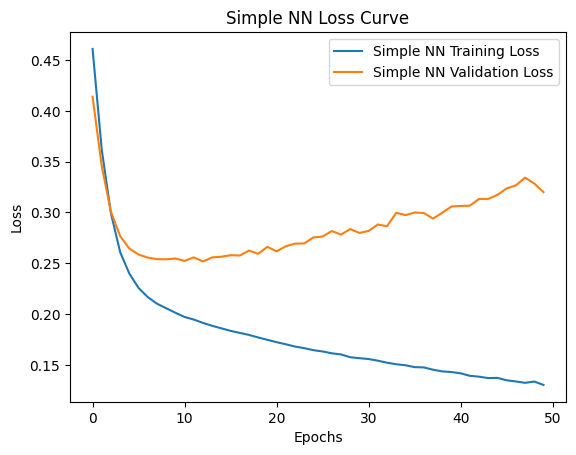

Training NN with L2 Regularization...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


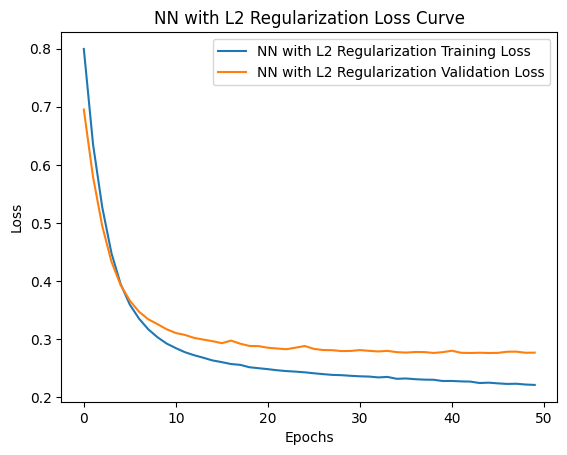

Training NN with Dropout...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


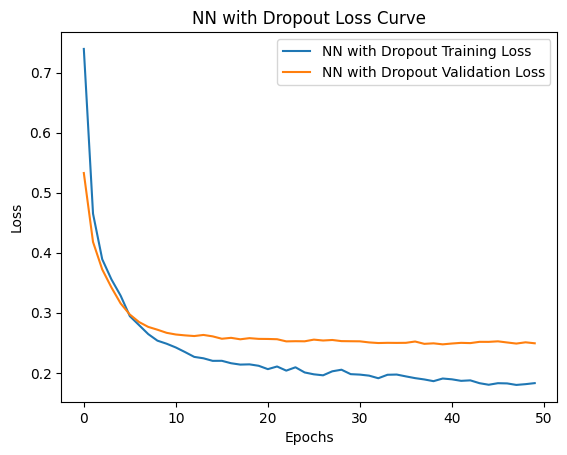

Training NN with Early Stopping...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


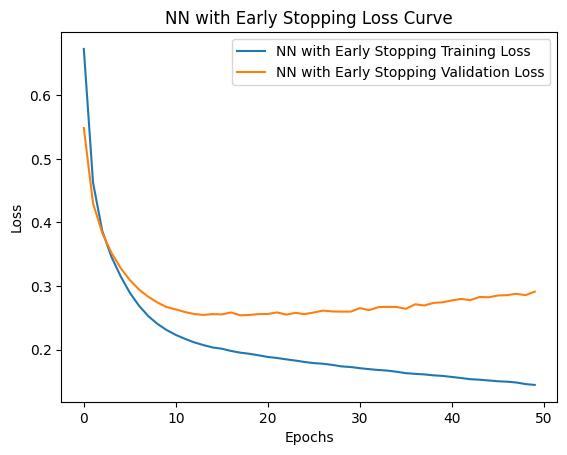

Training NN with L2 + Dropout + Early Stopping...
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


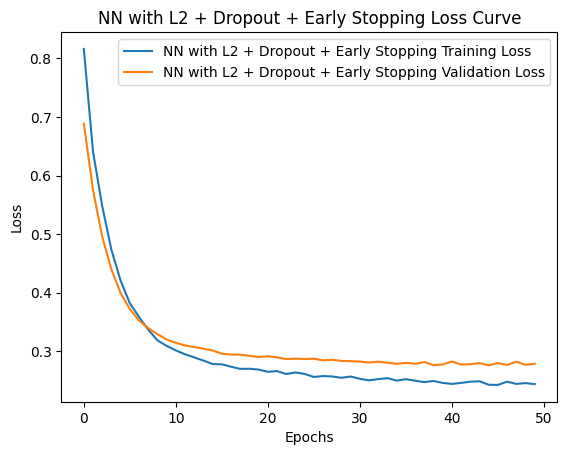

In [9]:
# Create and evaluate neural network models
nn_models = {
    "Simple NN": create_nn_model(),
    "NN with L2 Regularization": create_nn_model(regularizer=l2(0.01)),
    "NN with Dropout": create_nn_model(dropout_rate=0.2),
    "NN with Early Stopping": create_nn_model(early_stopping=True),
    "NN with L2 + Dropout + Early Stopping": create_nn_model(regularizer=l2(0.01), dropout_rate=0.2, early_stopping=True)
}

nn_results = {}
for name, model in nn_models.items():
    print(f"Training {name}...")
    history, metrics = train_and_evaluate_nn_model(model, X_train, y_train, X_test, y_test, "early_stopping" in name)
    nn_results[name] = metrics
    plt.plot(history.history["loss"], label=f"{name} Training Loss")
    plt.plot(history.history["val_loss"], label=f"{name} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name} Loss Curve")
    plt.legend()
    plt.show()

In [10]:
#Classical ML Models Implementation
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')  # Use 'liblinear' to support 'l1' penalty
param_grid_log_reg = {"C": [0.01, 0.1, 1, 10], "penalty": ["l2", "none"]}  # Removed 'l1' from penalties
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5)
grid_search_log_reg.fit(X_train, y_train)
log_reg_best = grid_search_log_reg.best_estimator_
log_reg_results = evaluate_model(log_reg_best, X_test, y_test)

svm = SVC(probability=True)
param_grid_svm = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_search_svm.fit(X_train, y_train)
svm_best = grid_search_svm.best_estimator_
svm_results = evaluate_model(svm_best, X_test, y_test)

decision_tree = DecisionTreeClassifier()
param_grid_dt = {"max_depth": [3, 5, 7, None], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}
grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)
dt_best = grid_search_dt.best_estimator_
dt_results = evaluate_model(dt_best, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

In [11]:
#Comparing all results
all_results = {**nn_results, "Logistic Regression": log_reg_results, "SVM": svm_results, "Decision Tree": dt_results}
print("Model Comparison:")
for model_name, metrics in all_results.items():
    print(f"{model_name}: Accuracy={metrics['Accuracy']:.4f}, Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1-Score={metrics['F1-Score']:.4f}")


Model Comparison:
Simple NN: Accuracy=0.8904, Precision=0.6570, Recall=0.7483, F1-Score=0.6997
NN with L2 Regularization: Accuracy=0.8836, Precision=0.6538, Recall=0.6755, F1-Score=0.6645
NN with Dropout: Accuracy=0.8667, Precision=0.5988, Recall=0.6623, F1-Score=0.6289
NN with Early Stopping: Accuracy=0.8497, Precision=0.5517, Recall=0.6358, F1-Score=0.5908
NN with L2 + Dropout + Early Stopping: Accuracy=0.8746, Precision=0.6235, Recall=0.6689, F1-Score=0.6454
Logistic Regression: Accuracy=0.8802, Precision=0.6380, Recall=0.6887, F1-Score=0.6624
SVM: Accuracy=0.8791, Precision=0.6170, Recall=0.7682, F1-Score=0.6844
Decision Tree: Accuracy=0.8633, Precision=0.5615, Recall=0.9073, F1-Score=0.6937


In [12]:
#Error analysis for the best model
best_model_name = max(all_results, key=lambda k: all_results[k]["Accuracy"])
if "NN" in best_model_name:
    best_model = nn_models[best_model_name]
else:
    best_model = {"Logistic Regression": log_reg_best, "SVM": svm_best, "Decision Tree": dt_best}[best_model_name]

if "NN" in best_model_name:
    y_pred = (best_model.predict(X_test) > 0.5).astype(int)
else:
    y_pred = best_model.predict(X_test)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


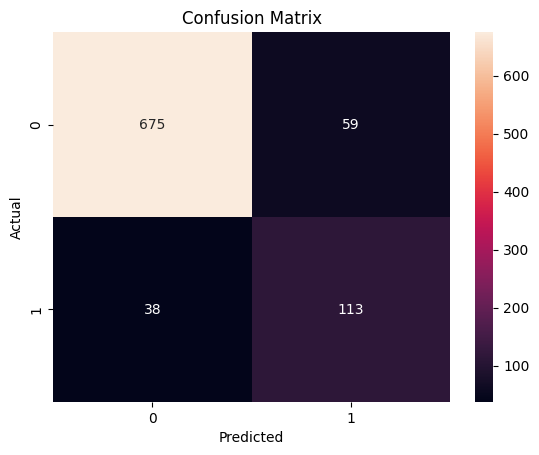

In [13]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


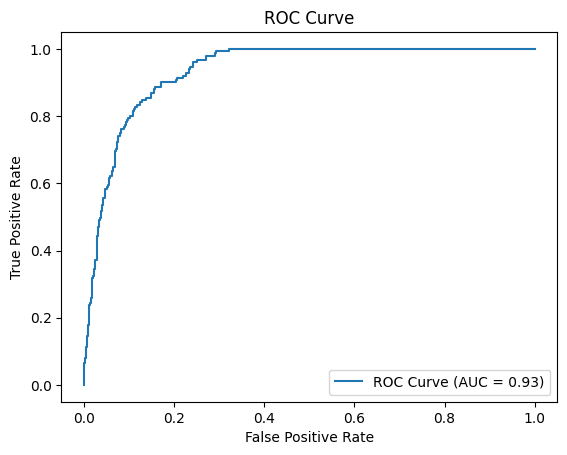

In [14]:
#ROC Curve
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_proba = best_model.decision_function(X_test)
else:
    y_proba = best_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [25]:
# Create directory for saving models
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Load dataset
data = pd.read_csv("/content/School_dataset.csv")
# Preprocessing
X = data.drop(columns=['Target'])
y = data['Target']

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder # This line is added to import the necessary class

# Encoding categorical target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.pkl"))

# Neural Network Model
# Import Sequential from tensorflow.keras.models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # Import necessary layers


def create_nn():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_model = create_nn()
nn_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, verbose=1)

# Save Neural Network Model
nn_model.save(os.path.join(MODEL_DIR, "nn_model.h5"))

# Classical ML Models
models = {
    "logistic_regression": LogisticRegression(),
    "svm": SVC(probability=True),
    "decision_tree": DecisionTreeClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, os.path.join(MODEL_DIR, f"{name}.pkl"))

print("All models have been trained and saved successfully!")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2457 - loss: -1.3831 - val_accuracy: 0.2768 - val_loss: -22.9628
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2987 - loss: -64.6553 - val_accuracy: 0.3277 - val_loss: -326.2226
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3334 - loss: -525.5850 - val_accuracy: 0.3404 - val_loss: -1359.1283
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3463 - loss: -1825.3586 - val_accuracy: 0.3475 - val_loss: -3437.6890
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3612 - loss: -4432.9072 - val_accuracy: 0.3573 - val_loss: -6844.1982
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3436 - loss: -8406.2783 - val_accuracy: 0.3559 - val_loss: -12002.5850
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3448 - loss: -14316.2559 - val_accuracy: 0.3630 - val_loss: -18939.6855
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0

All models have been trained and saved successfully!


In [26]:
# Comparing all results
all_results = {**nn_results, "Logistic Regression": log_reg_results, "SVM": svm_results, "Decision Tree": dt_results}
print("Model Comparison:")
for model_name, metrics in all_results.items():
    print(f"{model_name}: Accuracy={metrics['Accuracy']:.4f}, Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1-Score={metrics['F1-Score']:.4f}")


Model Comparison:
Simple NN: Accuracy=0.8904, Precision=0.6570, Recall=0.7483, F1-Score=0.6997
NN with L2 Regularization: Accuracy=0.8836, Precision=0.6538, Recall=0.6755, F1-Score=0.6645
NN with Dropout: Accuracy=0.8667, Precision=0.5988, Recall=0.6623, F1-Score=0.6289
NN with Early Stopping: Accuracy=0.8497, Precision=0.5517, Recall=0.6358, F1-Score=0.5908
NN with L2 + Dropout + Early Stopping: Accuracy=0.8746, Precision=0.6235, Recall=0.6689, F1-Score=0.6454
Logistic Regression: Accuracy=0.8802, Precision=0.6380, Recall=0.6887, F1-Score=0.6624
SVM: Accuracy=0.8791, Precision=0.6170, Recall=0.7682, F1-Score=0.6844
Decision Tree: Accuracy=0.8633, Precision=0.5615, Recall=0.9073, F1-Score=0.6937


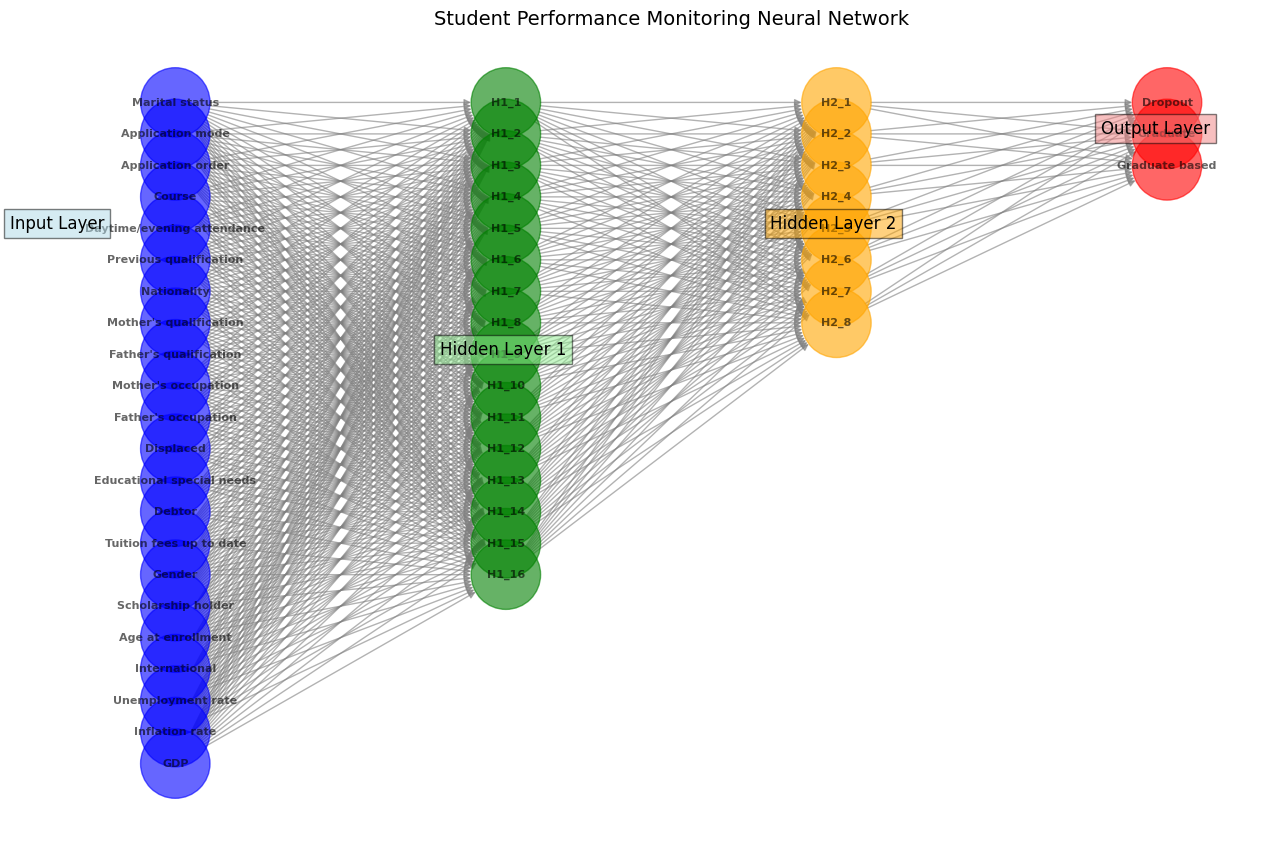

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

# Define layers
input_neurons = ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance',
                 'Previous qualification', 'Nationality', 'Mother\'s qualification', 'Father\'s qualification',
                 'Mother\'s occupation', 'Father\'s occupation', 'Displaced', 'Educational special needs', 'Debtor',
                 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
                 'Unemployment rate', 'Inflation rate', 'GDP']
hidden_layer_1 = [f'H1_{i}' for i in range(1, 17)]
hidden_layer_2 = [f'H2_{i}' for i in range(1, 9)]
output_neurons = ['Dropout', 'Graduate', 'Graduate based']

# Create a directed graph
G = nx.DiGraph()

# Define X-axis positions for each layer
layer_positions = {
    'input': 0,
    'hidden_1': 1,
    'hidden_2': 2,
    'output': 3
}

# Add nodes
pos = {}  # Store positions of nodes for plotting

# Add input layer nodes
for i, neuron in enumerate(input_neurons):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['input'], -i)

# Add hidden layer 1 nodes
for i, neuron in enumerate(hidden_layer_1):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['hidden_1'], -i)

# Add hidden layer 2 nodes
for i, neuron in enumerate(hidden_layer_2):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['hidden_2'], -i)

# Add output layer nodes
for i, neuron in enumerate(output_neurons):
    G.add_node(neuron)
    pos[neuron] = (layer_positions['output'], -i)

# Connect input layer to hidden layer 1
for input_neuron in input_neurons:
    for h1_neuron in hidden_layer_1:
        G.add_edge(input_neuron, h1_neuron)

# Connect hidden layer 1 to hidden layer 2
for h1_neuron in hidden_layer_1:
    for h2_neuron in hidden_layer_2:
        G.add_edge(h1_neuron, h2_neuron)

# Connect hidden layer 2 to output layer
for h2_neuron in hidden_layer_2:
    for output_neuron in output_neurons:
        G.add_edge(h2_neuron, output_neuron)

# Define colors for different layers
color_map = {node: 'blue' for node in input_neurons}
color_map.update({node: 'green' for node in hidden_layer_1})
color_map.update({node: 'orange' for node in hidden_layer_2})
color_map.update({node: 'red' for node in output_neurons})

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2500, font_size=8, font_weight='bold',
        node_color=[color_map[node] for node in G.nodes()], edge_color='gray', alpha=0.6)

# Add layer labels
plt.text(-0.5, -4, "Input Layer", fontsize=12, bbox=dict(facecolor='lightblue', alpha=0.5))
plt.text(0.8, -8, "Hidden Layer 1", fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.text(1.8, -4, "Hidden Layer 2", fontsize=12, bbox=dict(facecolor='orange', alpha=0.5))
plt.text(2.8, -1, "Output Layer", fontsize=12, bbox=dict(facecolor='lightcoral', alpha=0.5))

plt.title("Student Performance Monitoring Neural Network", fontsize=14)
plt.show()
